In [5]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


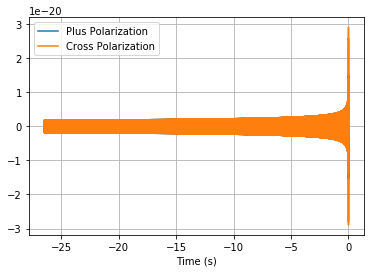

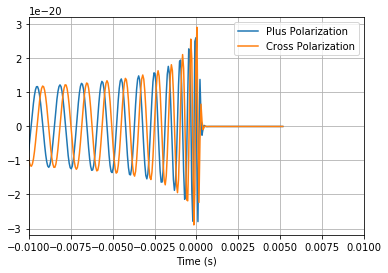

In [6]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4T",
                     mass1=1.35,
                     mass2=1.3795,#chirp mass equation
                     spin1z=0.0,    
                     spin2z=0.0,        
                     delta_t=1.0/16384 ,#4096
                     f_lower=40)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

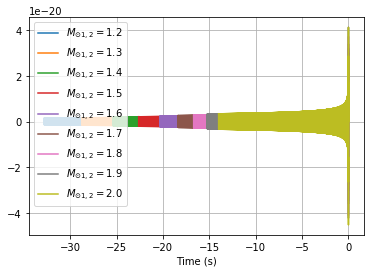

In [7]:
for m in [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:  #1.18 -1.97
    hp, hc = get_td_waveform(approximant="SEOBNRv4T",
                     mass1=m,
                     mass2=m,
                     spin1z=0.0,    
                     spin2z=0.0,        
                     delta_t=1.0/16384 ,#4096
                     f_lower=40)
    
    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()



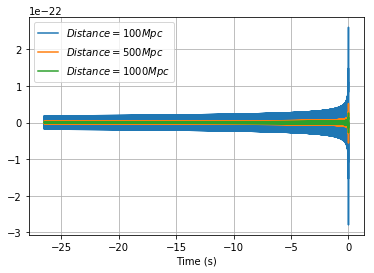

In [8]:
for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4T",
                     mass1=1.35,
                     mass2=1.3795,#chirp mass equation
                     spin1z=0.0,    
                     spin2z=0.0,        
                     delta_t=1.0/16384 ,#4096
                     f_lower=40,
                     distance=d)
    
    
    pylab.plot(hp.sample_times, hp, label='$Distance=%sMpc$' % d)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()



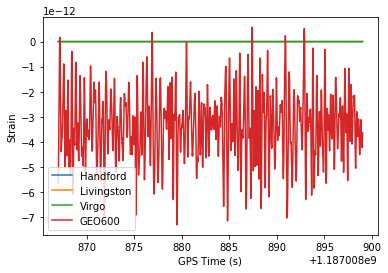

In [28]:
from pycbc import catalog
import pylab

event= catalog.Merger("GW170817") 

strainhan= event.strain('H1',sample_rate=16384)
strainliv= event.strain('L1',sample_rate=16384)
strainvir= event.strain('V1',sample_rate=16384)
straingeo= event.strain('G1',sample_rate=16384)


pylab.plot(strainhan.sample_times, strainhan, label='Handford')
pylab.plot(strainliv.sample_times, strainliv, label='Livingston')
pylab.plot(strainvir.sample_times, strainvir, label='Virgo')
pylab.plot(straingeo.sample_times, straingeo, label='GEO600')

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

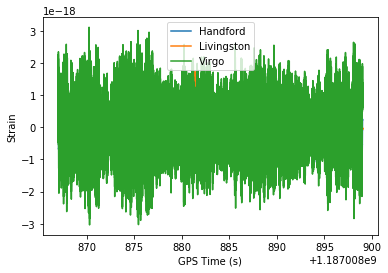

In [29]:
pylab.plot(strainhan.sample_times, strainhan, label='Handford')
pylab.plot(strainliv.sample_times, strainliv, label='Livingston')
pylab.plot(strainvir.sample_times, strainvir, label='Virgo')
pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

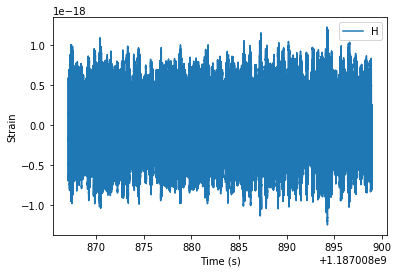

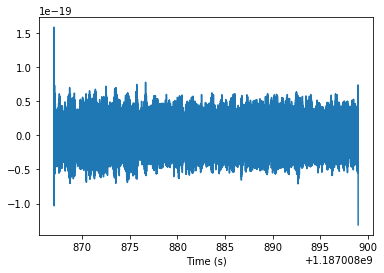

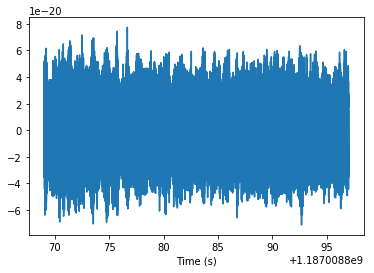

458752


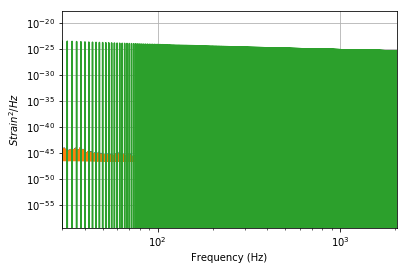

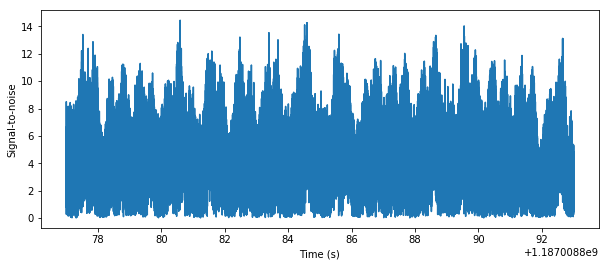

It is found a signal at 1187008880.59s with SNR 14.4423592621


In [21]:
#Data analysis
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
#HANFORD
#Remove the low frequency content 
strainhan= highpass(strainhan, 15.0)
#resample_to_delta_t(, 1.0/2048) no for this case
pylab.plot(strainhan.sample_times, strainhan)
pylab.xlabel('Time (s)')
pylab.show()
#Remove 2 seconds of data from both the beginning and end
#could be other seconds
conditionedhan= strainhan.crop(2,2)
pylab.plot(conditionedhan.sample_times, conditionedhan)
pylab.xlabel('Time (s)')
pylab.show()
# Estimate the power spectral density
from pycbc.psd import interpolate, inverse_spectrum_truncation

'''
Welch method used in article: The spectral estimate used to whiten the data in Figure 2 was found by
applying a Welch average to 1024 s of data centered on GPS time 1126259462 (the
nearest integer GPS time to the peak of the GW150914 signal). The data were broken
up into overlapping 4 s long chunks, each spaced by 2 s.
'''

#We use 4 second sapmles of our time series in Welch method.
psdhan= conditionedhan.psd(4)
#Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psdhan= interpolate(psdhan, conditionedhan.delta_f)
psdhan= inverse_spectrum_truncation(psdhan, 4 * conditionedhan.sample_rate,
                                  low_frequency_cutoff=15)

pylab.loglog(psdhan.sample_frequencies, psdhan)
pylab.grid()
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')

#xlim:depends on resolution, dates 16KHz----> 2048
pylab.xlim(30,2048)
#Tukey Window

'''
We need to apply a window function 
to our time-domain data before transforming, which we can do using the scipy.signal module:
'''

from scipy import signal
#from scipy.signal import get_window


windowhan= signal.tukey(len(conditionedhan),alpha=0.25)#DOUBT: I did not find the exact value
strainhanw =  conditionedhan * windowhan

psdhanw= strainhanw.psd(4)
psdhanw= interpolate(psdhanw, strainhanw.delta_f)
psdhanw= inverse_spectrum_truncation(psdhanw, 4 * strainhanw.sample_rate,
                                  low_frequency_cutoff=30)

pylab.loglog(psdhanw.sample_frequencies, psdhanw)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(30, 2048)


#print(len(conditionedhan))
#print(len(strainhanw))
#print(len(psdhan))
#print(len(psdhanw))
from pycbc.waveform import get_td_waveform
import pylab


#In a search we would grid over the parameters and calculate the SNR time series for each one

hphan, hchan = get_td_waveform(approximant="SEOBNRv4T",  
                     mass1=1.35,
                     mass2=1.3795,#chirp mass equation
                     spin1z=0.0,    
                     spin2z=0.0,        
                     delta_t=1.0/16384 ,#4096
                     f_lower=40)#f_lower=20 is to low

# We will resize the vector to match our data
hphan.resize(len(conditionedhan))


'''

m = 1.35 # Solar masses
hphan, hcan = get_td_waveform(approximant="SEOBNRv4T",
                     mass1=m,
                     mass2=m,
                     #delta_t=conditionedhan.delta_t,
                     delta_t=1.0/16384,         
                     f_lower=100)

hphan.resize(len(strainhanw))

print(1/conditionedhan.delta_t)

'''
# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
templatehan = hphan.cyclic_time_shift(hphan.start_time) ##
print(len(templatehan))
pylab.plot(templatehan)
pylab.show()

#print(len(conditionedhan))
#print(len(templatehan))
#print(len(strainhanw))
# signal-to-noise time series

from pycbc.filter import matched_filter
import numpy



snrhan= matched_filter(templatehan,strainhanw,
                     psd=psdhanw, low_frequency_cutoff=30)
                     
               

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snrhan= snrhan.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snrhan.sample_times, abs(snrhan))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peakhan = abs(snrhan).numpy().argmax()
snrphan = snrhan[peakhan]
timehan = snrhan.sample_times[peakhan]

print("It is found a signal at {}s with SNR {}".format(timehan, 
                                                    abs(snrphan)))
#DOUBT: is it ok?

#Aligning and Subtracting the Proposed Signal


from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dthan = timehan - conditionedhan.start_time
alignedhan = templatehan.cyclic_time_shift(dthan)

# scale the template so that it would have SNR 1 in this data
alignedhan /= sigma(alignedhan, psd=psdhanw, low_frequency_cutoff=30.0)

# Scale the template amplitude and phase to the peak value
alignedhan = (alignedhan.to_frequencyseries() * snrphan).to_timeseries()
alignedhan.start_time = strainhanw.start_time



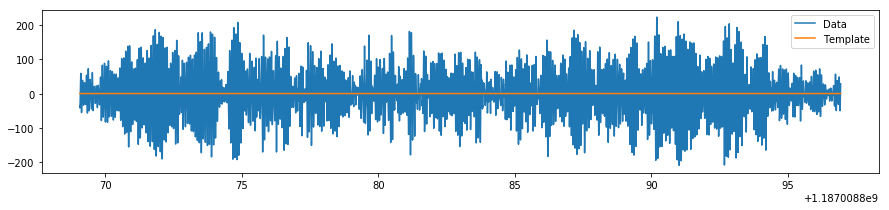

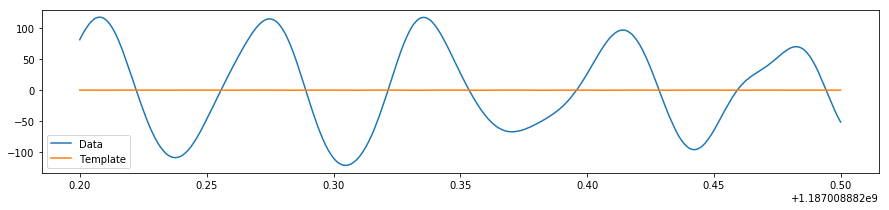

In [19]:
#Visualize the overlap between the signal and data


#DOUBT: how to choose correct bandpass?


# We do it this way so that we can whiten both the template and the data
white_datahan = (strainhanw.to_frequencyseries() / psdhanw**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
taperedhan = alignedhan.highpass_fir(30, 512, remove_corrupted=False)
white_templatehan = (taperedhan.to_frequencyseries() / psdhanw**0.5).to_timeseries()

white_datahan = white_datahan.highpass_fir(30., 512).lowpass_fir(30., 512)
white_templatehan = white_templatehan.highpass_fir(30., 512).lowpass_fir(30., 512)

pylab.figure(figsize=[15, 3])
pylab.plot(white_datahan.sample_times, white_datahan, label="Data")
pylab.plot(white_templatehan.sample_times, white_templatehan, label="Template")
pylab.legend()
pylab.show()
# Select the time around the merger
white_datahan = white_datahan.time_slice(event.time-.2, event.time+.1)
white_templatehan= white_templatehan.time_slice(event.time-.2, event.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_datahan.sample_times, white_datahan, label="Data")
pylab.plot(white_templatehan.sample_times, white_templatehan, label="Template")
pylab.legend()
pylab.show()

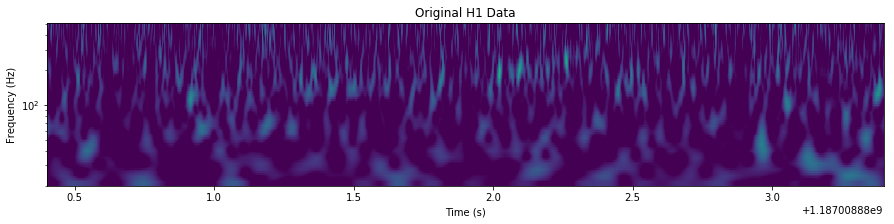

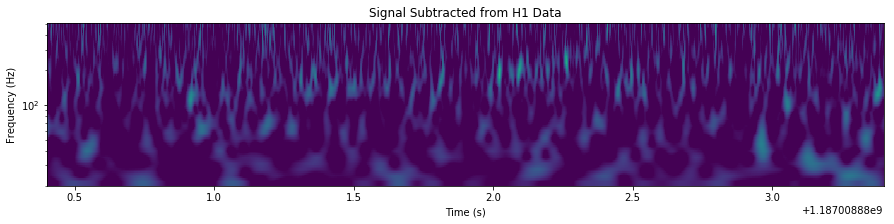

In [20]:

#DOUBT: what is incorrect?

subtractedhan= conditionedhan - alignedhan

# Plot the original data and the subtracted signal data

for data, title in [(conditionedhan, 'Original H1 Data'),
                    (subtractedhan, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(0.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20,512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(event.time - 2, event.time + 1)
    pylab.show()
